# 1) NECESSARY TO RUN

# Load Processed Data

In [1]:
with open("data/names_ascii.txt") as f:
    names = f.readlines()

In [2]:
names

['aba\n',
 'abaca\n',
 'abacan\n',
 'abac\n',
 'abay\n',
 'abayhan\n',
 'abaza\n',
 'abbas\n',
 'abdal\n',
 'abdi\n',
 'abdullah\n',
 'abdurrahman\n',
 'abdulalim\n',
 'abdulazim\n',
 'abdulaziz\n',
 'abdulbaki\n',
 'abdulbari\n',
 'abdulbasir\n',
 'abdulbasit\n',
 'abdulcabbar\n',
 'abdulcebbar\n',
 'abdulcelil\n',
 'abdulcemal\n',
 'abdulcevat\n',
 'abdulezel\n',
 'abdulferit\n',
 'abdulfettah\n',
 'abdulgaffar\n',
 'abdulgaffur\n',
 'abdulgafur\n',
 'abdulgani\n',
 'abdulhadi\n',
 'abdulhak\n',
 'abdulhakim\n',
 'abdulhalik\n',
 'abdulhalim\n',
 'abdulhamit\n',
 'abdulkadir\n',
 'abdulkahhar\n',
 'abdulkerim\n',
 'abdullatif\n',
 'abdulmecit\n',
 'abdulmelik\n',
 'abdulmennan\n',
 'abdulmetin\n',
 'abdulnasir\n',
 'abdulvahap\n',
 'abdulvahit\n',
 'abdurrahim\n',
 'abdurrahman\n',
 'abdurrauf\n',
 'abdurresit\n',
 'abdurrezzak\n',
 'abdussamet\n',
 'abdussami\n',
 'abdusselam\n',
 'abdussemi\n',
 'abdussettar\n',
 'abduzzeki\n',
 'abgul\n',
 'abher\n',
 'abihayat\n',
 'abir\n',
 'ab

# Prepare Data

## Tokenizer

In [3]:
import tensorflow as tf
import numpy as np

In [4]:
# create tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
)

In [5]:
# fit in data
tokenizer.fit_on_texts("".join(names))

In [6]:
char_to_index = tokenizer.word_index
index_to_char = dict((v, k) for k, v in char_to_index.items())

print(index_to_char)

{1: '\n', 2: 'a', 3: 'e', 4: 'i', 5: 'n', 6: 'u', 7: 'r', 8: 'l', 9: 's', 10: 'k', 11: 't', 12: 'm', 13: 'y', 14: 'g', 15: 'd', 16: 'b', 17: 'o', 18: 'h', 19: 'c', 20: 'z', 21: 'f', 22: 'v', 23: 'p', 24: 'j'}


## Seq to Name and Name to Seq

In [7]:
def name_to_seq(name):
    return [tokenizer.texts_to_sequences(ch)[0][0] for ch in name]

In [8]:
def seq_to_name(seq):
    return "".join([index_to_char[i] for i in seq])

In [9]:
# find max len
max_len = max([len(name) for name in names])
print(max_len)

15


In [10]:
# find number of characters
num_chars = len(char_to_index) + 1 # +1 is null character(0)
print(num_chars)

25


# 2) TRAIN MODEL (Optional)

## Create sequences and pad sequences to same length

In [63]:
# create sequences
sequences = []

for name in names:
    seq = name_to_seq(name)
    if len(seq) >= 2:
        sequences += [seq[:i] for i in range(2, len(seq) + 1)]

print(len(sequences))
sequences[:10]

79755


[[2, 16],
 [2, 16, 2],
 [2, 16, 2, 1],
 [2, 16],
 [2, 16, 2],
 [2, 16, 2, 19],
 [2, 16, 2, 19, 2],
 [2, 16, 2, 19, 2, 1],
 [2, 16],
 [2, 16, 2]]

In [96]:
# pad sequences (padding pre because in padded sequences last character will be label)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_len, padding="pre"
)

padded_sequences[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2, 16])

In [97]:
# create X and y data
X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]

print(X.shape, y.shape)

(79755, 14) (79755,)


# Train Test Split

In [35]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, X_test.shape)

(13780, 26) (4594, 26)


# Create Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM, Dense

In [40]:
# create model
model = Sequential([
                    Embedding(num_chars, 8, input_length=max_len-1),
                    # causal because future character should not affect prediction
                    Conv1D(64, 3, strides=1, activation="tanh", padding="causal"), 
                    MaxPool1D(2),
                    LSTM(64),
                    Dense(num_chars, activation="softmax")
])

# compile model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Train Model

In [42]:
h = model.fit(
    X_train, y_train,
    epochs=50, verbose=2,
    validation_data=(X_test, y_test),
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
    ]
)

Epoch 1/50
431/431 - 8s - loss: 2.5099 - accuracy: 0.2576 - val_loss: 2.1365 - val_accuracy: 0.3722
Epoch 2/50
431/431 - 5s - loss: 2.0333 - accuracy: 0.4077 - val_loss: 1.9468 - val_accuracy: 0.4288
Epoch 3/50
431/431 - 5s - loss: 1.8504 - accuracy: 0.4561 - val_loss: 1.8208 - val_accuracy: 0.4636
Epoch 4/50
431/431 - 5s - loss: 1.7628 - accuracy: 0.4806 - val_loss: 1.7712 - val_accuracy: 0.4743
Epoch 5/50
431/431 - 5s - loss: 1.7117 - accuracy: 0.4925 - val_loss: 1.7260 - val_accuracy: 0.4817
Epoch 6/50
431/431 - 5s - loss: 1.6735 - accuracy: 0.4993 - val_loss: 1.7028 - val_accuracy: 0.4887
Epoch 7/50
431/431 - 5s - loss: 1.6398 - accuracy: 0.5113 - val_loss: 1.6849 - val_accuracy: 0.4978
Epoch 8/50
431/431 - 5s - loss: 1.6139 - accuracy: 0.5168 - val_loss: 1.6691 - val_accuracy: 0.5026
Epoch 9/50
431/431 - 5s - loss: 1.5866 - accuracy: 0.5257 - val_loss: 1.6518 - val_accuracy: 0.5041
Epoch 10/50
431/431 - 5s - loss: 1.5590 - accuracy: 0.5318 - val_loss: 1.6379 - val_accuracy: 0.5141

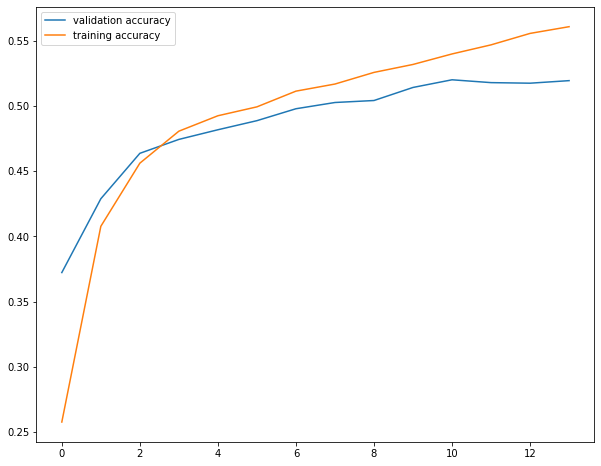

In [44]:
# visualize training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

num_epochs = len(h.history["loss"])
plt.plot(range(num_epochs), h.history["val_accuracy"], label="validation accuracy")
plt.plot(range(num_epochs), h.history["accuracy"], label="training accuracy")
plt.legend()

In [82]:
# save the model
model.save("data/tr_name_generate_model.h5")

# 3) TEST MODEL

## Load Model

In [11]:
model = tf.keras.models.load_model("model/tr_name_generate_model.h5")

## Create Turkish Names

In [12]:
def generate_names(seed=""):
    """Gets a seed (char or string)
    
    In a loop, predicts next chars and appends them to seed
    Next chars are chosen using probabilities to create different names each time
    
    Returns created name"""
    
    for i in range(40):
        # prepare sequence
        seq = name_to_seq(seed)
        padded = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=max_len-1,
                                                               padding="pre", 
                                                               truncating="pre")
        
        # predict next char
        probs = model.predict(padded)[0]
        index = np.random.choice(list(range(num_chars)), p=probs.ravel())

        if index == 0:
            break

        pred_char = index_to_char[index]
        seed += pred_char

        if pred_char == "\n":
            break

    return seed

In [13]:
def is_real_name(name):
    """checks whether created name is in names dataset or not"""
    for real_name in names:
        if name == real_name:
            return True
    return False

In [14]:
# create a turkish name
created = generate_names(seed="")
print(created)

ebari



In [15]:
# create 10 turkish names
for i in range(10):
    created = generate_names(seed="")
    print(created)

altan

adulkan

uluenman

akdagol

aran

ugurserk

ozullal

erbahir

olaytul

ulucah



In [27]:
# you can seed initial characters
seed = "g"
for i in range(5):
    created = generate_names(seed=seed)
    print(created)

gulsen

gulyeme

gucelbal

gungum

gulhan



In [33]:
# create unseen names
seed = "as"
i = 0
name_count = 5

while i < name_count:
    created = generate_names(seed=seed)
    
    if is_real_name(created):
        continue
    else:
        print(created)
        i += 1

asmac

asirye

asabey

asilcan

asum



In [34]:
# check whether a created name is real or not
is_real_name("alinaz")

False